In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

from google.colab import drive
import os

This notebook is for augmenting your dataset. There are a number of functions that employ traditional image augmentation techniques. 

Important Note: At this point I started working in Google Colab instead of Jupyter notebook. If you're going to run the neural network in the future, you'll want to be working in Colab, so for me it was easier to start storing the data in Colab in preparation for this. Of course, this is optional, so I will make the filepaths as general as possible, but the default will assume that the data is stored in the home page of Google Colab.

Also note: the first three cells are just functions. You should be able to ignore the second two, use the first one if you need to resize images.

In [1]:
def resize_images(images, labels):
  """
  This function will resize images/labels if needed. Really only important if you need to make
  adjustments to your deep learning model and adjust the input size of the images.

  Also maybe you decide to stick with large images when labeling and want to resize them here. 

  Parameters:
    images (ndarray): numpy array of color images (meaning they have three channels (RGB))
    labels (ndarray): numpy array of labels
  """
  #Output images will be this size
  new_dim = (256,256)

  if is_color:
    resized_images = np.zeros((len(image_names),*new_dim,3))
  else:
      resized_images = np.zeros((len(image_names),*new_dim))
  resized_labels = np.zeros((labels.shape[0], *new_dim))

  for i, img in enumerate(images):
    label = labels[i]

    new_test = np.zeros((2048, 2048, 4))
    new_test[:,:,:3] = img

    dim = (new_dim, new_dim)
      
    # resize image
    resized_img = cv2.resize(new_test, dim, interpolation = cv2.INTER_AREA)
    resized_label = cv2.resize(label, dim, interpolation = cv2.INTER_AREA)

    resized_images[i] = resized_img[:,:,:3] / 255.

    mask = resized_label > 0
    resized_label[mask] = 255.

    resized_labels[i] = resized_label
  
  return resized_images, resized_labels

In [2]:
#The following is a long list of helper functions for the original transformation functions.
#Basically these functions accept an image and transformation parameters and perform the transformation.
#The next cell will randomly chose these parameters and call these functions.

def translate_image_helper(im, a, b):
  trans_image = np.zeros_like(im)

  for j in range(3):
    c = im[:,:,j]

    new_image1 = np.zeros_like(c)
    new_image2 = new_image1.copy()
    
    p1 = c[:,:a]
    p2 = c[:,a:]
    
    new_image1 = np.column_stack((p2,p1))
    
    p1 = new_image1[:b,:]
    p2 = new_image1[b:,:]

    new_image2 = np.vstack((p2,p1))

    trans_image[:,:,j] = new_image2

  return trans_image

def translate_label_helper(label, a, b):
       
  new_image1 = np.zeros_like(label)
  new_image2 = new_image1.copy()
  
  p1 = label[:,:a]
  p2 = label[:,a:]
  
  new_image1 = np.column_stack((p2,p1))
  
  p1 = new_image1[:b,:]
  p2 = new_image1[b:,:]

  new_image2 = np.vstack((p2,p1))

  return new_image2




def rotation_image_helper(im, t):
  trans_image = np.zeros_like(im)
  for i in range(3):

    image = im[:,:,i]

    d1, d2 = image.shape
        
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
    #Create rotation matrix
    rotation_matrix = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
    
    new_coords = rotation_matrix@coords
    new_coords = new_coords.astype(int)
    
    x, y = new_coords.reshape((2, d1, d2), order='F')
    trans_image[:,:,i] = np.take(image, x+d1*y, mode='wrap').reshape((d1, d2))
  return trans_image

def rotation_label_helper(label, t):
  d1, d2 = label.shape
      
  coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
  
  #Create rotation matrix
  rotation_matrix = np.array([[np.cos(t), -np.sin(t)], [np.sin(t), np.cos(t)]])
  
  new_coords = rotation_matrix@coords
  new_coords = new_coords.astype(int)
  
  x, y = new_coords.reshape((2, d1, d2), order='F')
  new_image = np.take(label, x+d1*y, mode='wrap').reshape((d1, d2))

  return new_image




def skew_image_helper(im, a):
  trans_image = np.zeros_like(im)

  for i in range(3):
    image = im[:,:,i]
   
    d1, d2 = image.shape
    
    #Create coordinate matrix
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
    rotation_matrix = np.array([[1,a], [0,1]])
    
    new_coords = rotation_matrix@coords
    new_coords = new_coords.astype(int)
    
    x, y = new_coords.reshape((2, d1, d2), order='F')
    trans_image[:,:,i] = np.take(image, x+d1*y, mode='wrap').reshape((d1, d2))

  return trans_image

def skew_label_helper(label, a):
  d1, d2 = label.shape
      
  coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
  rotation_matrix = np.array([[1,a], [0,1]])
  
  new_coords = rotation_matrix@coords
  new_coords = new_coords.astype(int)
  
  x, y = new_coords.reshape((2, d1, d2), order='F')

  new_image = np.take(label, x+d1*y, mode='wrap').reshape((d1, d2))

  return new_image




def horizontal_image_helper(im):
  trans_image = np.zeros_like(im)

  for i in range(3):

    image = im[:,:,i]

    d1, d2 = image.shape
        
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
    #Do a rotation using theta = pi
    rotation_matrix = np.array([[-1,0], [0,-1]])
    
    new_coords = rotation_matrix@coords
    new_coords = new_coords.astype(int)
    
    x, y = new_coords.reshape((2, d1, d2), order='F')

    trans_image[:,:,i] = np.take(image, x+d1*y, mode='wrap').reshape((d1, d2))

  return trans_image

def horizontal_label_helper(label):
  d1, d2 = label.shape
        
  coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
  
  #Do a rotation using theta = pi
  rotation_matrix = np.array([[-1,0], [0,-1]])
  
  new_coords = rotation_matrix@coords
  new_coords = new_coords.astype(int)
  
  x, y = new_coords.reshape((2, d1, d2), order='F')

  new_image = np.take(label, x+d1*y, mode='wrap').reshape((d1, d2))

  return new_image



def noise_image_helper(im, vals):
  trans_image = np.zeros_like(im)

  for i in range(3):

    image = im[:,:,i]
    
    d1, d2 = image.shape
    
    #Create coordinate matrix
    coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
    new_coords = coords + vals
    new_coords = new_coords.astype(int)
    
    x, y = new_coords.reshape((2, d1, d2), order='F')
    trans_image[:,:,i] = np.take(image, x+d1*y, mode='wrap').reshape((d1, d2))

  return trans_image

def noise_label_helper(label, vals):
  d1, d2 = label.shape
        
  coords = np.mgrid[0:d1, 0:d2].reshape((2,d1*d2))
    
  new_coords = coords + vals
  new_coords = new_coords.astype(int)
  
  x, y = new_coords.reshape((2, d1, d2), order='F')

  new_image = np.take(label, x+d1*y, mode='wrap').reshape((d1, d2))

  return new_image





In [ ]:
#These functions perform an identical transformation on both image and label and return the transformed image and label

def translate(images, labels, A, B): 
    """Returns each image translated by a random amount (a,b), where
    a~Uniform(-A,A) and b~Uniform(-B,B). The resulting image should be cropped
    to be of size (d1,d2). Note that this translation will leave a border on
    two sides of the image. Fill the empty border with the parts that were cropped
    off the opposite sides.
        Parameters:
            images (d1,d2): d1 x d2 array 
            A (float): horizontal translation parameter
            B (float): vertical translation parameter
        Returns:
            translated_image (d1,d2): array of translated images
    """
    new_images = np.zeros_like(images)
    new_labels = np.zeros_like(labels)
    
    #For each image in set...
    for i,image in enumerate(images):
        #Randomize a and b values
        a = np.random.randint(-A,A)
        b = np.random.randint(-B,B)
        
        #This is an awful way to implement this but I couldn't find another way
        #I basically just create new images by splicing everything by ha

        if is_color:
          new_images[i] = translate_image_helper(image, a, b)
        else:
          new_images[i] = translate_label_helper(image, a, b)
        new_labels[i] = translate_label_helper(labels[i], a, b)
    
    return new_images, new_labels
    
    
    
def rotate(images, labels, theta): 
    """ Returns an image rotated by a random amount t~Uniform(-theta,theta).
    The resulting image should be cropped to be the same size as the original,
    and any blank parts should be filled with one of the parts cropped off the
    other side.
        Parameters:
            images (d1,d2): d1 x d2 array
            theta (float): largest acceptable rotation angle
        Returns:
            rotated_image (d1,d2): array of rotated image
    """
    
    new_images = np.zeros_like(images)
    new_labels = np.zeros_like(labels)
    
    #For each image in set...
    for i,image in enumerate(images):
        #Randomize a theta value
        t = np.random.uniform(-theta, theta)
        
        if is_color:
          new_images[i] = rotation_image_helper(image, t)
        else:
          new_images[i] = rotation_label_helper(image, t)
        new_labels[i] = rotation_label_helper(labels[i], t)
    
    return new_images, new_labels

    
def skew(images, labels, A): 
    """ Returns an image with the linear transformation [[1,a],[0,1]] applied,
    where a~Uniform(-A,A). Crop the parts that go outside the image boundaries
    and fill missing areas with the appropriate cropped piece.
        Parameters:
            images (d1,d2): d1 x d2 array
            A (float): skew parameter
        Returns:
            skewed_image (d1,d2): array of skewed image
    """
    new_images = np.zeros_like(images)
    new_labels = np.zeros_like(labels)

    #For each image in set...
    for i,image in enumerate(images):
        #Randomize a value
        a = np.random.uniform(-A, A)
        
        if is_color:
          new_images[i] = skew_image_helper(image, a)
        else:
          new_images[i] = skew_label_helper(image, a)
        new_labels[i] = skew_label_helper(labels[i], a)
    
    return new_images, new_labels

def flip_horizontal(images, labels):
    """Flip horizontal. Returns a horizontally flipped version of each image.
        Parameters:
            images (d1,d2): d1 x d2 image array 
        Returns:
            flipped_image (d1,d2): array of flipped image
    """
    
    new_images = np.zeros_like(images)
    new_labels = np.zeros_like(labels)
    
    #For each image in set...
    for i,image in enumerate(images):
        
        if is_color:
          new_images[i] = horizontal_image_helper(image)
        else:
          new_images[i] = horizontal_label_helper(image)
        new_labels[i] = horizontal_label_helper(labels[i])
    
    return new_images, new_labels

    
def gauss_noise(images, labels, sigma2): 
    """Adds Gaussian noise with parameter sigma2. For each image draw d1xd2 random
    noise values from N(0,sigma2) and add those to the original image.
        Parameters:
            images (d1,d2): d1 x d2 array 
        Returns:
            noisy_image: array of noisy image
    """
    new_images = np.zeros_like(images)
    new_labels = np.zeros_like(labels)
    
    #For each image in set...
    for i,image in enumerate(images):
        
        d1, d2, c = image.shape 
        
        vals = np.random.normal(0,sigma2, d1*d2)
        
        if is_color:
          new_images[i] = noise_image_helper(image, vals)
        else:
          new_images[i] = noise_label_helper(image, vals)
        new_labels[i] = noise_label_helper(labels[i], vals)

    
    return new_images, new_labels
    

### Code starts here

In [ ]:
#Only run this cell if you are working in Colab and are storing your data there
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Adjust this path to point to where your images and labels are stored.
path = '/content/gdrive/MyDrive'

#Change these based on the names of your image and label files
data_file = 'data.npy'
label_file = 'labels.npy'

#This value should be true for images with 3 channels (RGB channels) and false for black and white.
#Basically it adjusts the size of the array built to store new images
is_color = True

In [ ]:
#Load images and labels
images = np.load(os.path.join(path, data_file))
labels = np.load(os.path.join(path, label_file))

In [ ]:
def image_augment(X,Y,parameters, num):
    """ transform the images using the functions above. 
    Parameters:
        X (N,d1,d2): array containing N images of dimension d1 x d2
        Y (N,): Labels/values for each image
        parameters: List of parameter values [A,B,theta,A,sigma2]
        num (int): Number of times you want to augment each image/label pair
    Returns:
        augmented_X (num*N,d1,d2): original and transformed data in one array 
        augmented_Y (num*N): corresponding labels/values
    """
    
    #Unpack parameters
    A1,B,theta,A2,sigma2 = parameters[0],parameters[1],parameters[2],parameters[3],parameters[4]
    
    #List of available transformations
    transformations = [translate, rotate, skew, flip_horizontal, gauss_noise]
    
    #Create parameters dictionary mapping transformations to corresponding parameters
    params = {translate: [A1,B], rotate:[theta], skew:[A2], gauss_noise:[sigma2],flip_horizontal:[]}
    
    n,d1,d2,c = X.shape
    augmented_images = np.zeros(((n*5*num)+n,d1,d2,c))
    augmented_labels = np.zeros(((n*5*num)+n,d1,d2))
    
    augmented_images[:n] = X
    augmented_labels[:n] = Y
    
    #Transform images
    for i in range(num):
      for j,t in enumerate(transformations):
        new_images, new_labels = t(X,Y,*params[t])
        augmented_images[(n*(j+1) + 5*n*i):(n*(j+2) + 5*n*i)] = new_images
        augmented_labels[(n*(j+1) + 5*n*i):(n*(j+2) + 5*n*i)] = new_labels
    
    return augmented_images, augmented_labels

In [ ]:
#These parameters correspond to the transformation functions
translate_param1 = int(images[0].shape[1] / 2)
translate_param2 = int(images[0].shape[0] / 2)
rotate_param = np.pi / 2
skew_param = 1
gauss_param = 1

parameters = [translate_param1,translate_param2,rotate_param, skew_param, gauss_param]

#Number of times to perform each transformation on each image
#NOTE - this will result in 5 * num * num_images new images.
num = 6

aug_images, aug_labels = image_augment(images, labels, parameters, num)

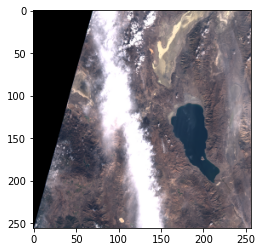

In [ ]:
#Sample to make sure it worked
plt.imshow(aug_images[100])

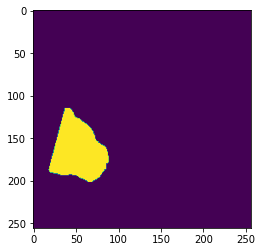

In [ ]:
plt.imshow(aug_labels[100])

In [ ]:
#Save augmented images and labels at original path provided
#Adjust path and filenames as desired
os.chdir(path)
np.save('augmented_images.npy', aug_images)
np.save('augmented_labels.npy', aug_labels)

# Experimental Stuff

The following is an idea I had for a different kind of image augmentation. Instead of transforming an augmented image, I would take full sized images, and look at smaller 'windows' of that image. One big difference is that your new dataset will potentially contain a lot of new images that don't contain any wildfire, but this might be a good thing as it could help train a model that can truly distinguish when there is or isn't fire. One issue though is if you get too many images without fire, your model might start predicting that everything doesn't have fire and still obtain a reasonable accuracy.

In [ ]:
aug_images = np.load(os.path.join('/content/gdrive/MyDrive', 'augmented_images.npy'))
aug_labels = np.load(os.path.join('/content/gdrive/MyDrive', 'augmented_labels.npy'))

In [ ]:
#Desire size of window
new_dim = 256

#Size of starting image
#For example, default is 2048 becuase original images were 2048x2048
starting_size = 2048
limit = starting_size - 1 - new_dim

#Number of 'windows' to grab from original image
num_images = 10

#Assumes RGB images, not black and white
num, height, width, channels = images.shape
new_images = np.zeros((num*num_images, new_dim, new_dim, channels))
new_labels = np.zeros((num*num_images, new_dim, new_dim))

for i,img in enumerate(images):
  label = labels[i]
  for j in range(num_images):
    a = np.random.randint(limit)
    b = np.random.randint(limit)
    new_im = img[a:a+new_dim,b:b+new_dim]
    new_l = label[a:a+new_dim,b:b+new_dim]

    new_images[num_images*i + j] = new_im
    new_labels[num_images*i + j] = new_l

In [ ]:
np.save('new_augmented_images.npy', new_images)
np.save('new_augmented_labels.npy', new_labels)

In [ ]:
#This code adds the transformed images and labels from above to the new 'windows' set
old_num = aug_images.shape[0]
new_num = new_images.shape[0]

final_aug_images = np.zeros((old_num + new_num, 256,256,3))
final_aug_labels = np.zeros((old_num + new_num, 256,256))

final_aug_images[:old_num] = aug_images
final_aug_images[old_num:] = new_images

final_aug_labels[:old_num] = aug_labels
final_aug_labels[old_num:] = new_labels

In [ ]:
np.save('final_augmented_images.npy', final_aug_images)
np.save('final_augmented_labels.npy', final_aug_labels)